#Problema de valores iniciales: Péndulo doble

##Autor: Manuel Dafonte Urbizu

En este trabajo trataremos de resolver un problema de valores iniciales, en concreto el del péndulo doble. Las ecuaciones que lo describen no se pueden resolver analíticamente por lo que antes de poder resolver dicho problema, veremos varios métodos para poder resolver ecuaciones que tienen el mismo problema.

En concreto realizaremos los siguientes métodos: Euler, Euler mejorado, Runge-Kutta, Runge-Kutta mejorado, métodos predictor-corrector mejorados (Milne 4to y 6to y Adams-Bashford-Moulton).

Como es lo habitual, primero programaremos los métodos anteriormente mencionados y los iremos comprobando con una función bien conocida, un oscilador subamortiguado en este caso.

Pasamos a la programación:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML


##Euler:

###Simple:
Hemos programado dos métodos de Euler, el simple y el mejorado. Ambos métodos son métodos de un paso basados en fórmulas de cuadratura.

Tomando la aproximación:

\begin{equation}
  \int_{x_i}^{x_{i+1}}f(x,y(x))dx\approx (x_{i+1}-x_i) \cdot f(x_i,y(x_i))
\end{equation}

Podemos ver claramente que la función $f$ será la derivada de la solución a nuestra ecuación diferencial $y(x)$. Esta fórmula corresponde a la de interpolación de grado cero con un único nodo $x_i$ por lo que podremos escribir:

\begin{equation}
  y_{i+1}=y_i +h\cdot f(x_i,y_i)
\end{equation}

Esta expresión nos proporciona los valores de nuestra solución en cada punto dada una condición inicial (de ahí el nombre de problema de valores iniciales). Esto ocurrirá con todos los métodos de forma similar. 

###Mejorado:
Para el caso de Euler mejorado aproximaremos la integral por la regla del trapecio, lo que nos proporciona la siguiente expresión:
\begin{equation}
  \int_{x_i}^{x_{i+1}}f(x,y(x))dx\approx \frac{h}{2} ( f(x_i,y_i)+ f(x_{i+1},y_{i+1}))
\end{equation}

Lo que, análogamente, nos permitirá escribir la siguiente ecuación:

\begin{equation}
  y_{i+1}=y_i + \frac{h}{2} ( f(x_i,y_i)+ f(x_{i+1},y_{i+1}))
\end{equation}

Aquí nos encontramos con un problema muy claro y es que la $y_{i+1}$ , que es lo que estamos tratando de calcular, aparece de forma implícita en nuestra ecuación. La solución que le daremos a este problema será aproximar $y_{i+1}$ mediante el método de Euler simple (nombramos a ese resultado por $y^*_{i+1}$. Quedándonos la siguiente relación:

\begin{equation}
  y_{i+1}=y_i + \frac{h}{2} ( f(x_i,y_i)+ f(x_{i+1},y^*_{i+1}))
\end{equation}

En cuanto a la codificación, programamos la función $oscilador$ que será la que usaremos gran parte del trabajo. Aunque no dependa de x, la programamos como si así fuera porque programaremos los métodos para cualquier función (incluyendo las que sí dependen explícitamente de x). Podemos observar que nos devuelve las derivadas ([velocidad, aceleración]) de los elementos de y ([posición, velocidad]).

Los métodos se entienden claramente con la teoría explicada anteriormente. Y el integrador será la función que nos permitirá resolver la ecuación diferencial en el intervalo que nosotros le indiquemos.

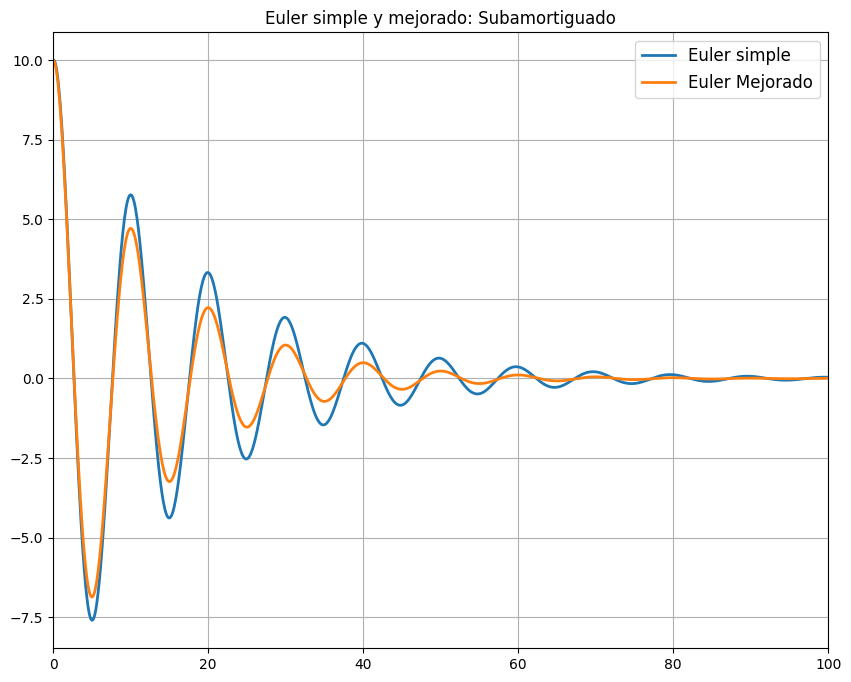

In [3]:
#Definimos la función

def oscilador(x,y): #no depende de x, y[pos, vel]
  k = 0.4
  lam = 0.15
  return np.array([y[1], -k*y[0] -lam*y[1] ])

def euler_simple(x0,y0,f,h):
  return y0+h*f(x0,y0)

def euler_mej(x0,y0,f,h):
  x1=x0+h
  return y0+(h*0.5*(f(x0,y0)+f(x1,euler_simple(x0,y0,f,h))))

def int1(x0,xf,y0,f,h,metodo):
  x=[x0] #covertimos en listas
  y=[y0]
  while xf>x[-1]:
    y.append(metodo(x[-1],y[-1],f,h)) #guardamos los resultados
    x.append(x[-1]+h)
  return np.array(x), np.array(y)

#Valores iniciales

x0, xf = 0., 100.
y0=np.array([10., 0.])
h=0.1

#Representamos gráficamente: 

x1,y1=int1(x0,xf,y0,oscilador,h,euler_simple)
x2,y2=int1(x0,xf,y0,oscilador,h,euler_mej)

fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(x1,y1[:,0],label="Euler simple",linewidth=2)  
plt.plot(x2,y2[:,0],label="Euler Mejorado",linewidth=2, color='tab:orange')  
plt.legend(fontsize=12)
plt.grid()
plt.title('Euler simple y mejorado: Subamortiguado')
ax.set_xlim(x0,xf)
plt.show()

##Runge-Kutta

Los métodos de Runge-Kutta son varios, en este ejercicio sólo hemos programado el de Runge-Kutta que no es más que una fórma más eficiente del método de Kutta propuesto por Runge.

De hehco, los métodos de Euler son simplemente casos particulares de estos métodos.

Veamos la tabla de Butcher:

\begin{equation}
  \begin{matrix}
    0\\
    \frac{1}{2} & \frac{1}{2}\\
    \frac{1}{2} & 0 & \frac{1}{2}\\
    1 & 0 & 0 & 1\\
     &\frac{1}{6}&\frac{1}{3}& \frac{1}{3} &\frac{1}{6} \\
  \end{matrix}
\end{equation}

Por lo tanto el esquema computacional será:

\begin{gather}
  K1=f(x_i,y_i) \\
  K2=f\left(x_i+\frac{h}{2}, y_i+\left(\frac{h}{2}\cdot K1\right)\right)\\
  K3=f\left(x_i+\frac{h}{2}, y_i+\left(\frac{h}{2}\cdot K2\right)\right)\\
  K4=f\left(x_i+h,y_i+h\cdot K3\right)\\
  y_{i+1}=y_i+\frac{h}{6}\cdot(K1+2\cdot K2+2\cdot K3+K4)
\end{gather}

Este método en concreto está basado en la regla de Simpson tomando como nodos $\xi_0=x_i$, $\xi_1=x_i+\frac{h}{2}$, $\xi_2=x_i+h$, calcular el valor de la solución en $\xi_1=x_i+\frac{h}{2}$ usando el método de Euler, pero volviendo a calcular este valor utilizando el método de Euler implícito y tomar el promedio entre ambos.

###Mejora

Para la mejora hemos de aplicar la técnica de extrapolación de Richardson. En este caso compararemos la aproximación $y_{i+1,1}$ (obtenida integrando desde $x_i$ hasta $x_{i+1}$ con paso h) con la $y_{i+1,2}$ obtenida integrando en dos etapas con paso $\frac{h}{2}$.

Siguiendo estos pasos obtenemos la expresión, siendo $m$ el orden:


\begin{equation}
  y(x_{i+1})\approx \frac{y_{i+1,1}-2^my_{i+1,2}}{1-2^m}
\end{equation}

Esta es la mejor aproximación que podemos hacer a nuestra solución.

En cuanto al código no hay nada que comentar, de nuevo con la teoría expuesta en estos párrafos es trivial seguir el desarrollo computacional.

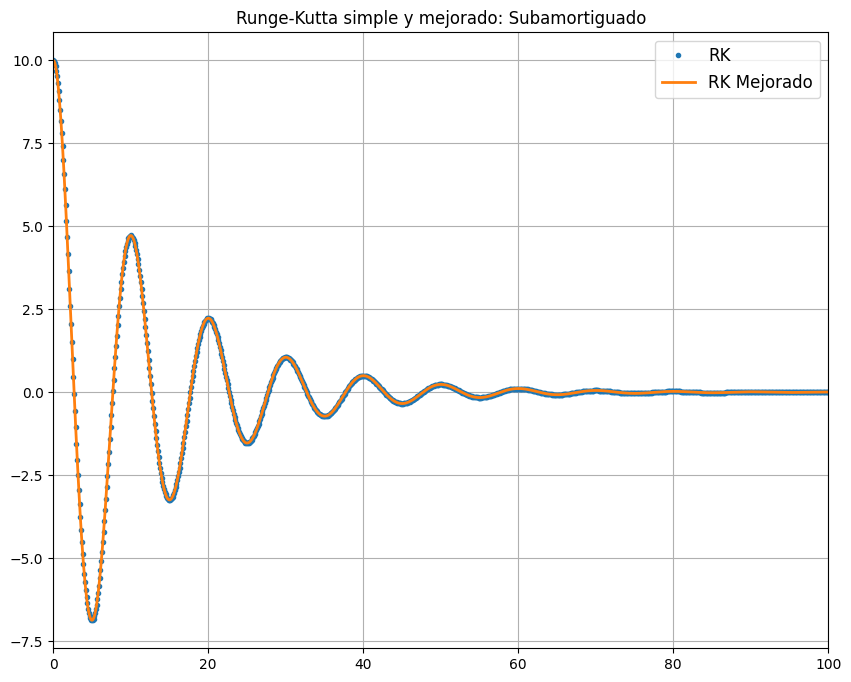

In [4]:
def RK (x,y,f,h):
  k1=f(x,y)
  k2=f(x+h/2, y+(h*k1/2))
  k3=f(x+h/2, y+(h*k2/2))
  k4=f(x+h,y+h*k3)
  return y+(h/6)*(k1+2*k2+2*k3+k4)


def RK_mej (x,y,f,h):
  m=4 #orden de Runge-Kutta
  y1=RK(x,y,f,h)
  yi=RK(x,y,f,h/2)
  y2=RK(x+h/2,yi,f,h/2)
  return (y1-(2**m)*y2)/(1-(2**m))

#Representación gráfica

x1,y1=int1(x0,xf,y0,oscilador,h,RK)
x2,y2=int1(x0,xf,y0,oscilador,h,RK_mej)

fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(x1,y1[:,0],'.',label="RK",linewidth=2)  
plt.plot(x2,y2[:,0],'-',label="RK Mejorado",linewidth=2, color='tab:orange')  
plt.legend(fontsize=12)
ax.set_xlim(x0,xf)
plt.grid()
plt.title('Runge-Kutta simple y mejorado: Subamortiguado')
plt.show()



##Pequeño análisis

Llegados a este punto conviene hacer un pequeño análisis de lo que hemos conseguido hasta el momento. Se han programado con éxito los métodos de Euler y Runge-Kutta con sus correspondientes mejoras.

Vemos claramente que el método de Euler es muy limitado y que su mejora cambia notablemente el resultado de nuestra función. 
Sin embargo, para el método de Runge-Kutta apenas se puede apreciar la diferencia entre ambos métodos. Por esa misma razón se ha decidido representar una de las curvas con puntos en vez de como un continuo.

Además, ambos métodos nos ofrecen una clara representación de un oscilador subamortiguadom que es el caso que estamos tratando, por lo que podemos afirmar que los métodos están funcionando como deberían.

##Multipaso

Pasamos ahora a programar los métodos multipaso, éstos requieren más que unas condiciones iniciales. Para que funcionen necesitan unos puntos de activación que han de calcularse usando otros métodos. En nuestro caso usaremos el Runge-Kutta mejorado ya que es el más preciso con el que contamos.

Programaremos tres métodos distintos de la categoría predictor-corrector, la base de este método es aplciar la misma técnica que usamos en Euler con mejora.

Tendremos una fórmula para predecir nuestro valor que tendrá una dependencia explicita de términos conocidos (predictora) y dicha predicción será usada en una expresión que tiene una dependencia implícita de la solución que estamos tratando de hallar (correctora).

Exponemos a continuación las fórmulas de predicción y corrección en cada caso.

###Método de Milne de 4º orden:
Predictora:

\begin{gather}
  y_{i+1}= y_{i-3} + \frac{4h}{3}(2f_i - f_{i-1} + 2f_{i-2})\\
  \sigma_{i+1}^*=\frac{14}{45}h^4f^{(4)}(\xi)\\
\end{gather}


Correctora:

\begin{gather}
  y_{i+1} = y_{i-1} + \frac{h}{3}(f_{i+1}+4f_i + f_{i-1})\\
  \sigma_{i+1}=-\frac{h^4}{90}f^{(4)}(\eta)\\
\end{gather}

###Método de Adams-Bashford-Moulton:

Predictora:

\begin{gather}
  y_{i+1}= y_i + \frac{h}{24}(55f_i - 59f_{i-1} + 37f_{i-2} - 9f_{i-3})\\
  \sigma_{i+1}^*=\frac{251}{720}h^4f^{(4)}(\xi)\\
\end{gather}


Correctora:

\begin{gather}
  y_{i+1} = y_{i-1} + \frac{h}{24}(9f_{i+1}+19f_i - 5f_{i-1} + f_{i-2})\\
  \sigma_{i+1}=-\frac{19}{720}h^4f^{(4)}(\eta)\\
\end{gather}

###Método de Milne de 6º orden:

Predictora:

\begin{gather}
  y_{i+1}= y_{i-5} + \frac{3h}{10}(11f_i - 14f_{i-1} + 26f_{i-2} -14f_{i-3} +11f_{i-4})\\
  \sigma_{i+1}^*=\frac{41}{140}h^6f^{(6)}(\xi)\\
\end{gather}


Correctora:

\begin{gather}
  y_{i+1} = y_{i-3} + \frac{2h}{45}(7f_{i+1}+32f_i + 12f_{i-1}+32f_{i-2} +7f_{i-3})\\
  \sigma_{i+1}=-\frac{8}{945}h^6f^{(6)}(\eta)\\
\end{gather}

En cuanto a la mejora, sabemos que $\sigma$ es el error de nuestra predicción, luego si restamos el valor real de la solución a lo predicho por nuestra teoría, nos dará sigma. Ejemplificaremos la obtención de la mejora con Adams-Bashford-Moulton y las demás se pueden sobreentender trivialmente.

Tenemos el siguiente sistema de ecuaciones:

\begin{gather}
  y(x_{i+1})-y^*_{i+1} \approx \frac{251}{720}h^4f^{(4)}(\xi)\\
  y(x_{i+1})-y^c_{i+1} \approx -\frac{19}{720}h^4f^{(4)}(\eta)\\
\end{gather}

Asumiendo que $f^{(4)}(\xi)\approx f^{(4)}(\eta)$ podemos despejar $y(x_{i+1}$ en función de $y^c_{i+1}$ & $y^*_{i+1}$. Ese resultado será una mejora de nuestro anterior valor para la correctora y lo denotaremos por $y^M_{i+1}$, quedándonos:

\begin{equation}
  y(x_{i+1}\approx y_{i+1}^M=\frac{251y_{i+1}^c+19y_{i+1}^*}{270}
\end{equation}

Ahora el error de truncamiento puede ser estimado mediante:

\begin{gather}
  h \sigma^*_{i+1} \approx y^M_{i+1}-y^*_{i+1} \approx \frac{251}{270}(y^c_{i+1}-y^*_{i+1})\\
  h \sigma_{i+1} \approx y^M_{i+1}-y^c_{i+1} \approx \frac{19}{270}(y^*_{i+1}-y^c_{i+1})
\end{gather}

Además si $f^{(4)}(\xi)$ no varía mucho entre $[x_{i-1},x_i]$ el error de truncamiento será $\sigma_{i+1}^*\approx\sigma_i^*$ por lo que podremos expresar:

\begin{equation}
  y^{*M}_{i+1}=y_{i+1}^*+h\sigma_i^*
\end{equation}

que conduce a:

\begin{equation}
  y^{*M}_{i+1}=y_{i+1}^*+\frac{251}{270}(y^c_{i}-y^*_{i})
\end{equation}


Por lo tanto:

###Milne de 4to orden con mejora:
\begin{gather}
  y_{i+1}^M=\frac{28y_{i+1}^c+y_{i+1}^*}{29}\\
  y_{i+1}^{*M}=y_{i+1}^*+\frac{28}{29}(y_{i}^c-y_{i}^*)\\
\end{gather}

###Adams-Bashford-Moulton de 4to orden con mejora:
\begin{gather}
  y_{i+1}^M=\frac{251y_{i+1}^c+19y_{i+1}^*}{270}\\
  y^{*M}_{i+1}=y_{i+1}^*+\frac{251}{270}(y^c_{i}-y^*_{i})\\
\end{gather}

###Milne de 6to orden con mejora:
\begin{gather}
  y_{i+1}^M=\frac{1107y_{i+1}^c+32y_{i+1}^*}{1139}\\
  y_{i+1}^{*M}=y_{i+1}^*+\frac{1107}{1139}(y_{i}^c-y_{i}^*)\\
\end{gather}

En cuanto a la codificación, hemos definido dos funciones distintas, la multipaso y la mejora del mismo. En cada una de ellas puedes seleccionar cualquiera de los tres métodos que hemos desarrollado aquí.

Hemos tenido que definir un nuevo integrador ya que, como comentábamos antes, estos métodos no son de autoarranque, por lo que se tendrán que calcular primero una serie de términos con otro método. Aunque se ha elegido Runge-Kutta con mejora por ser el mejor, podría elegirse otro sin alterar prácticamente nada el código. Además se ha programado para que calcule el mínimo número de términos posibles para activar la función.

Para la mejora, también devolveremos los elementos no mejorados ya que como hemos visto son necesarios para calcular las mejoras de los predictores.

El resto del código se puede seguir con los comentarios.


C:\Users\manue\AppData\Local\Temp\ipykernel_14856\3326199471.py:88: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ks" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x1,y1[:,0],'ks',label="Milne 4to orden",linewidth=2, color='tab:blue')


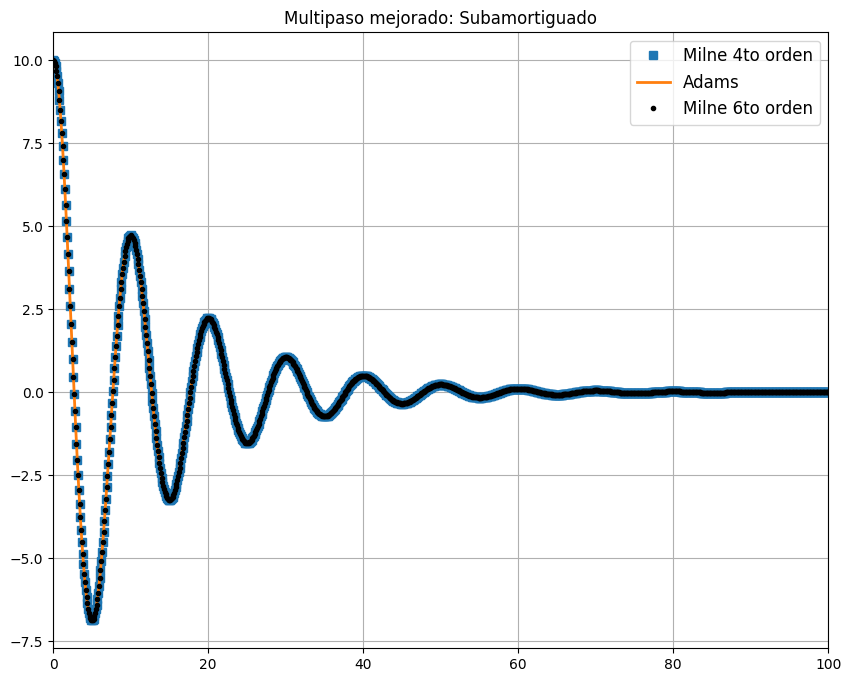

In [5]:
def multipaso (x,y,f,h,metodo): #metodo puede ser  "milne4" (0), "adams" (1) o "milne6" (2)
  f0=f(x[-1],y[-1]) #calculo de los términos de activación 
  f1=f(x[-2],y[-2])
  f2=f(x[-3],y[-3])
  
  if metodo == 'milne4' or 0: #Método de Milne de 4to orden
    #predictor 
    yp = y[-4]+(4*h/3)*(2*f0-f1+2*f2)
    #corrector 
    f01=f(x[-1]+h,yp)

    yc=y[-2]+(h/3)*(f01+4*f0+f1)
  
  elif metodo == 'adams' or 1: #Método de Adams
    f3=f(x[-4],y[-4]) #necesitamos mas terminos

    #predictor 
    yp = y[-1]+(h/24)*(55*f0-59*f1+37*f2-9*f3)
    #corrector 
    f01=f(x[-1]+h,yp)
    yc=y[-1]+(h/24)*(9*f01+19*f0-5*f1+f2)
  elif metodo == 'milne6' or 2: #Método de Milne de 6to orden
    f3=f(x[-4],y[-4]) #necesitamos mas terminos
    f4=f(x[-5],y[-5])

    #predictor 
    yp = y[-6]+(3*h/10)*(11*f0-14*f1+26*f2-14*f3+11*f4)
    #corrector 
    f01=f(x[-1]+h,yp)
    yc=y[-4]+(2*h/45)*(7*f01+32*f0+12*f1+32*f2+7*f3)
  else:
    print('Método incorrecto, ponga "milne4", "adams" o "milne6"') 

  return yp,yc 

def multi_mej(x,y,f,h,metodo,yp,yc): #solicita los valores predictor y corrector a mejorar
  if metodo == 'milne4' or 0:
    p, c = multipaso(x,y,f,h,0)
    ycm=(p+28*c)/29
    ypm=p+(28/29)*(yc[-1]-yp[-1])

  elif metodo == 'adams' or 1:
    p, c = multipaso(x,y,f,h,1)
    ycm=(251*c+19*p)/270
    ypm=p+(251/270)*(yc[-1]-yp[-1])

  elif metodo == 'milne6' or 2:
    p, c = multipaso(x,y,f,h,2)
    ycm=(32*p+1107*c)/1139
    ypm=p+(1107/1139)*(yc[-1]-yp[-1])

  else:
    print('Método incorrecto, ponga "milne4", "adams" o "milne6"')

  return ypm, ycm, p, c

def int2 (x0,xf,y0,f,h,metodo):
  #calculamos los minimos valores posibles para que funcione el metodo
  if metodo == 'milne4' or 0 or 'adams' or 1:
    x, y = int1(x0,x0+3*h,y0,f,h,RK_mej)
  elif metodo == 'milne6' or 2:
    x, y = int1(x0,x0+5*h,y0,f,h,RK_mej)
  else:
    print('Método incorrecto, ponga "milne4", "adams" o "milne6"')
  
  x=list(x)
  y=list(y)

  yp=[0.] #Valor '0' predictor y corrector para que funcione la mejora
  yc=[0.]

  while xf>x[-1]:
    ypm, ycm, ycs, yps=multi_mej(x,y,f,h,metodo,yp, yc)
    y.append(ycm)
    yp.append(yps)
    yc.append(ycs)
    x.append(x[-1]+h)
  return np.array(x), np.array(y)



x1 , y1= int2(x0,xf,y0,oscilador,h, 0)
x2 , y2= int2(x0,xf,y0,oscilador,h, 1)
x3 , y3= int2(x0,xf,y0,oscilador,h, 2)


fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(x1,y1[:,0],'ks',label="Milne 4to orden",linewidth=2, color='tab:blue')  
plt.plot(x2,y2[:,0],'-',label="Adams",linewidth=2, color='tab:orange')
plt.plot(x3,y3[:,0],'.',label="Milne 6to orden",linewidth=2, color='k')  
plt.legend(fontsize=12)
plt.grid()
plt.title('Multipaso mejorado: Subamortiguado')
ax.set_xlim(x0,xf)
plt.show()


##Análisis de resultados sobre los métodos programados:

Vemos que las diferencias entre los tres métodos predictor-corrector son imperceptibles, en el caso que nos ocupa sería recomendable usar o el de Milne de 4º orden o el de Adams porque estamos tratando con una función que es de orden 1. El de sexto orden funciona correctamente como es de esperar pero es un método muy potente para una función que no requiere tanto.

Hasta el momento hemos programado varios métodos que nos han permitido resolver numéricamente una ecuación diferencial bien conocida y que han demostrado su utilidad con creces, pasemos a ver un ejemplo más complejo donde podamos hacer un uso más adecuado de estos métodos tan potentes.

##Péndulo doble:

El péndulo doble será el sistema que pondremos bajo estudio utilizando los métodos programados anteriormente. Se trata de un sistema caótico, lo que quiere decir que con una variación infinitesimal en sus condiciones iniciales la evolución temporal del sistema varía enormemente.

Veamos las ecuaciones por las que viene descrito su movimiento:

\begin{gather}
 \ddot{\theta_1}=\frac{-g\cdot (2\cdot m_1+m_2)\cdot sin(\theta_1)-m_2\cdot g\cdot sin(\theta_1-2\cdot \theta_2)-2\cdot sin(\theta_1-\theta_2)\cdot m_2\cdot (\dot{\theta_2}^ 2\cdot l2+\dot{\theta_1}^ 2\cdot l1\cdot cos(\theta_1-\theta_2))}{l1\cdot (2\cdot m_1+m_2-m_2\cdot cos(2\cdot \theta_1-2\cdot \theta_2))}\\
 \ddot{\theta_2}=\frac{2\cdot sin(\theta_1-\theta_2)\cdot (\dot{\theta_1}^ 2\cdot l1\cdot (m_1+m_2)+g\cdot (m_1+m_2)\cdot cos(\theta_1)+\dot{\theta_2}^ 2\cdot l2\cdot m_2\cdot cos(\theta_1-\theta_2))}{l2\cdot (2\cdot m_1+m_2-m_2\cdot cos(2\cdot \theta_1-2\cdot \theta_2))}
\end{gather}

Vemos que son dos ecuaciones diferenciales de orden 2 y además están acopladas. Esto no va a suponer ningún problema, nuestras condiciones iniciales en este caso serán 4. Nuestra $y$ será:

$
\begin{align}
    \vec{y} &= \begin{bmatrix}
           \theta_1 \\
           \dot{\theta_1} \\
           \theta_2 \\
           \dot{\theta_2}
         \end{bmatrix}
  \end{align}
$

Por lo tanto nuestra $\vec{y'}=f(x,\vec{y})$:

$
\begin{align}
    \vec{f}(x,\vec{y}) &= \begin{bmatrix}
           \dot{\theta_1} \\
           \ddot{\theta_1} \\
           \dot{\theta_2} \\
           \ddot{\theta_2}
         \end{bmatrix}
  \end{align}
$

Ya tenemos todos los elementos que necesitamos para aplicar nuestros métodos programados, como ya hemos comprobado que funcionan correctamente hemos decidido usar solamente el método de Runge-Kutta mejorado para proceder al análisis del sistema.

Como es un sistema complejo haremos varias representaciones y simulaciones para facilitar lo máximo posible su entendimiento.


En la codificación de la función se hacen uso de argumentos ya que no hemos querido definir los parámetros del sistema dentro de la función para mantenerla lo más general posible.


In [9]:
#Parámetros del sistema (en sistema internacional)

g=9.81 #gravedad terrestre
m1=0.25
m2=1
l1=1
l2=1.5

def pendulo_doble(x,y,arg=(g,m1,m2,l1,l2)): 
  g = arg[0]
  m1 = arg[1]
  m2 = arg[2]
  l1 = arg[3]
  l2 = arg[4]

  #theta 1
  n1=-g*(2*m1+m2)*np.sin(y[0])-m2*g*np.sin(y[0]-2*y[2])-2*np.sin(y[0]-y[2])*m2*((y[3]**2)*l2+(y[1]**2)*l1*np.cos(y[0]-y[2])) #numerador
  d1=l1*(2*m1+m2-m2*np.cos(2*y[0]-2*y[2])) #denominador
  t1=n1/d1 #funcion

  #theta 2
  n2=2*np.sin(y[0]-y[2])*((y[1]**2)*l1*(m1+m2)+g*(m1+m2)*np.cos(y[0])+(y[3]**2)*l2*m2*np.cos(y[0]-y[2])) 
  d2=l2*(2*m1+m2-m2*np.cos(2*y[0]-2*y[2])) 
  t2=n2/d2 
  
  return np.array([y[1],t1,y[3],t2])


#Condiciones iniciales 
h=0.01
x0, xf = 0., 30.


y04 = np.array([(np.pi/4),0,(np.pi/5),0])
y01 = np.array([(np.pi/3),0,(np.pi/2),0])
y02 = np.array([(np.pi/3)+0.3,0,(np.pi)-0.1,0]) 
y03 = np.array([(np.pi/3)+0.35,0,(np.pi)-0.05,0])

x4,y4 = int1(x0,xf,y04,pendulo_doble,h,RK_mej)
x1,y1 = int1(x0,xf,y01,pendulo_doble,h,RK_mej)
x2,y2 = int1(x0,xf,y02,pendulo_doble,h,RK_mej)
x3,y3 = int1(x0,xf,y03,pendulo_doble,h,RK_mej)


#Represenctación gráfica

fig, ax = plt.subplots(nrows=3,ncols=2,figsize=(20, 30))
fig.suptitle(r'Varias representaciones para el péndulo doble. Condiciones iniciales comunes: $g=9.81\frac{m}{s^2} \quad m_1=0.25 kg \quad m_2=1 kg \quad l_1=1 m \quad l_2= 1.5 m$', fontsize=16)

ax[0,0].plot(x4,y4[:,0],'-',label="Masa 1",linewidth=2)  
ax[0,0].plot(x4,y4[:,2],'-',label="Masa 2",linewidth=2, color='tab:orange')  
ax[0,0].legend(fontsize=12)
ax[0,0].set_xlim(x0,xf)
ax[0,0].set_xlabel(r'$t$')
ax[0,0].set_ylabel(r'$\theta (t)$')
ax[0,0].grid()
ax[0,0].set_title('Posiciones m1 y m2: 'r'$y_{01}=\left(\frac{\pi}{4}, 0, \frac{\pi}{5}, 0\right)$')

ax[0,1].plot(y4[:,0],y4[:,1],'-',label="Masa 1",linewidth=2)  
ax[0,1].plot(y4[:,2],y4[:,3],'-',label="Masa 2",linewidth=2, color='tab:orange')  
ax[0,1].legend(fontsize=12)
ax[0,1].set_xlabel(r'$\theta (t)$')
ax[0,1].set_ylabel(r'$\dot{\theta} (t)$')
ax[0,1].grid()
ax[0,1].set_title('Espacio de fases m1 y m2: 'r'$y_{01}=\left(\frac{\pi}{4}, 0, \frac{\pi}{5}, 0\right)$')


ax[1,0].plot(x1,y1[:,0],'-',label="Masa 1",linewidth=2)  
ax[1,0].plot(x1,y1[:,2],'-',label="Masa 2",linewidth=2, color='tab:orange')  
ax[1,0].legend(fontsize=12)
ax[1,0].set_xlim(x0,xf)
ax[1,0].set_xlabel(r'$t$')
ax[1,0].set_ylabel(r'$\theta (t)$')
ax[1,0].grid()
ax[1,0].set_title('Posiciones m1 y m2: 'r'$y_{02}=\left(\frac{\pi}{3}, 0, \frac{\pi}{2}, 0\right)$')

ax[1,1].plot(y1[:,0],y1[:,1],'-',label="Masa 1",linewidth=2)  
ax[1,1].plot(y1[:,2],y1[:,3],'-',label="Masa 2",linewidth=2, color='tab:orange')  
ax[1,1].legend(fontsize=12)
ax[1,1].set_xlabel(r'$\theta (t)$')
ax[1,1].set_ylabel(r'$\dot{\theta} (t)$')
ax[1,1].grid()
ax[1,1].set_title('Espacio de fases m1 y m2: 'r'$y_{02}=\left(\frac{\pi}{3}, 0, \frac{\pi}{2}, 0\right)$')

ax[2,0].plot(x2,y2[:,2],'-',label="C.I. 2: Masa 2",linewidth=2)  
ax[2,0].plot(x3,y3[:,2],'-',label="C.I. 3: Masa 2",linewidth=2, color='tab:orange')  
ax[2,0].legend(fontsize=12)
ax[2,0].set_xlim(x0,xf)
ax[2,0].set_xlabel(r'$t$')
ax[2,0].set_ylabel(r'$\theta (t)$')
ax[2,0].grid()
ax[2,0].set_title('Posición masa 2 con C.I.: 'r'$y_{03}=\left(\frac{\pi}{3}+0.3, 0, \pi-0.1, 0\right)$ & $y_{04}=\left(\frac{\pi}{3}+0.35, 0, \pi-0.05, 0\right)$')


ax[2,1].plot(y2[:,2],y2[:,3],'-',label="C.I. 2: Masa 2",linewidth=2)  
ax[2,1].plot(y3[:,2],y3[:,3],'-',label="C.I. 3: Masa 2",linewidth=2, color='tab:orange')  
ax[2,1].legend(fontsize=12)
ax[2,1].set_xlabel(r'$\theta (t)$')
ax[2,1].set_ylabel(r'$\dot{\theta} (t)$')
ax[2,1].grid()
ax[2,1].set_title('Espacio de fases m2 con 'r'$y_{03}=\left(\frac{\pi}{3}+0.3, 0, \pi-0.1, 0\right)$ & $y_{04}=\left(\frac{\pi}{3}+0.35, 0, \pi-0.05, 0\right)$')




plt.show()





TypeError: subplots() got multiple values for argument 'nrows'

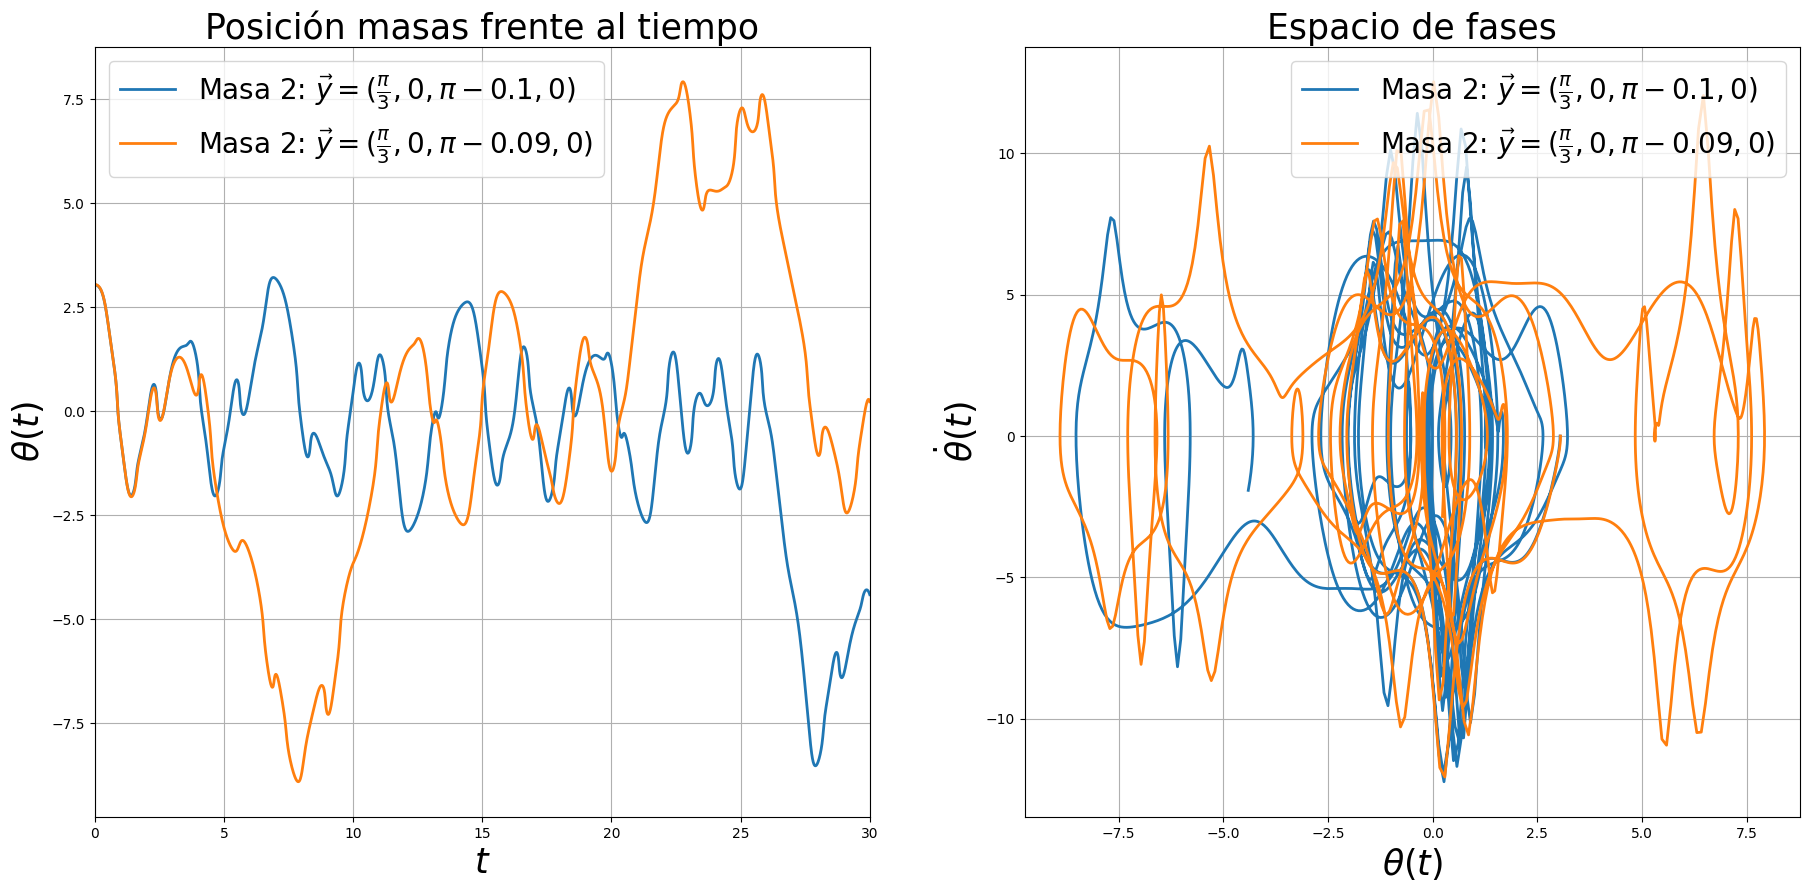

In [34]:
y02 = np.array([(np.pi/3),0,(np.pi)-0.1,0]) 
y03 = np.array([(np.pi/3),0,(np.pi)-0.09,0])
x2,y2 = int1(x0,xf,y02,pendulo_doble,h,RK_mej)
x3,y3 = int1(x0,xf,y03,pendulo_doble,h,RK_mej)


fig, ax = plt.subplots(ncols=2,figsize=(22, 10))

ax[0].plot(x2,y2[:,2],'-',label=r"Masa 2: $\vec{y}=(\frac{\pi}{3},0,\pi-0.1,0)$",linewidth=2)  
ax[0].plot(x3,y3[:,2],'-',label=r"Masa 2: $\vec{y}=(\frac{\pi}{3},0,\pi-0.09,0)$",linewidth=2, color='tab:orange')  
ax[0].legend(fontsize=20)
ax[0].set_xlim(x0,xf)
ax[0].set_xlabel(r'$t$',fontsize=25)
ax[0].set_ylabel(r'$\theta (t)$',fontsize=25)
ax[0].grid()
ax[0].set_title('Posición masas frente al tiempo',fontsize=25)


ax[1].plot(y2[:,2],y2[:,3],'-',label=r"Masa 2: $\vec{y}=(\frac{\pi}{3},0,\pi-0.1,0)$",linewidth=2)  
ax[1].plot(y3[:,2],y3[:,3],'-',label=r"Masa 2: $\vec{y}=(\frac{\pi}{3},0,\pi-0.09,0)$",linewidth=2, color='tab:orange')  
ax[1].legend(fontsize=20)
ax[1].set_xlabel(r'$\theta (t)$', fontsize=25)
ax[1].set_ylabel(r'$\dot{\theta} (t)$',fontsize=25)
ax[1].grid()
ax[1].set_title('Espacio de fases',fontsize=25)

plt.savefig('pendulo_doble bienn.pdf')

plt.show()



In [7]:
#Definimos una función para cambiar de coordenadas polares a cartesianas

def cambio(x,y): 
  x1=l1*np.sin(y[:,0])
  y1=-l1*np.cos(y[:,0])
  x2=x1+l2*np.sin(y[:,2])
  y2=y1-l2*np.cos(y[:,2])

  A=np.zeros((len(x1),4)) #matriz donde almacenamos posiciones
  

  A[:,0]=x1
  A[:,1]=y1
  A[:,2]=x2
  A[:,3]=y2
  
  return A


A=cambio(x2,y2)

#Para que no tarde tanto quitamos puntos de la trayectoria
trayect1 = A[::2,:] # uno de cada 2

fig = plt.figure(figsize=(6, 4))
# Vamos a fijar los límites de la figura para superponer los distintos resultados
ax = fig.add_subplot(111, autoscale_on=False, xlim=(min(trayect1[:,2])-0.1, max(trayect1[:,2]+0.1)), ylim=(min(trayect1[:,3])-0.1, max(trayect1[:,3]+0.1)))

#Definimos los valores de la traza, el punto y las cuerdas (listas vacías)
line1, = ax.plot([], [], '-', lw=2)
point1, = ax.plot([], [], 'ro',color='b')
line2, = ax.plot([], [], '-', lw=2)
point2, = ax.plot([], [], 'ro',color='tab:red')

line3, = ax.plot([], [], '-', lw=2, color='k')
line4, = ax.plot([], [], '-', lw=2, color='k')

# llamamos a la función para realizar cada fotograma de la trayectoria 
# para cada tiempo t
def run(t, trayectoria):
    line1.set_data(trayectoria[:t,0], trayectoria[:t,1]) # trayectoria seguida por m1
    point1.set_data(trayectoria[t,0], trayectoria[t,1]) # masa 1
    line2.set_data(trayectoria[:t,2], trayectoria[:t,3]) # trayectoria m2
    point2.set_data(trayectoria[t,2], trayectoria[t,3]) # masa 2
    line3.set_data([0,trayectoria[t,0]], [0,trayectoria[t,1]]) # Cuerda pendulo masa 1-0
    line4.set_data([trayectoria[t,0],trayectoria[t,2]], [trayectoria[t,1],trayectoria[t,3]]) #cuerda pendulo masa 2-1
    return line1, point1, line2, point2, line3, line4

anim1 = animation.FuncAnimation(fig, run, interval=20, frames=trayect1.shape[0],
                               fargs=[trayect1,], repeat=False)
plt.close()
HTML(anim1.to_html5_video()) #animamos

C:\Users\manue\AppData\Local\Temp\ipykernel_14856\833896576.py:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  point1, = ax.plot([], [], 'ro',color='b')
C:\Users\manue\AppData\Local\Temp\ipykernel_14856\833896576.py:33: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  point2, = ax.plot([], [], 'ro',color='tab:red')


RuntimeError: Requested MovieWriter (ffmpeg) not available

In [ ]:
HTML(anim1.to_jshtml()) 

##Análisis y conclusión final:

Hemos representado 6 figuras para poder entender lo mejor porsible el comportamiento tan característico de este sistema. La primera columna siempre respresenta posición frente a tiempo y la segunda el espacio de fases. Todas las figuras tienen la misma gravedad, masas y longitudes que están especificadas en el título principal de la figura.

En la primera fila podemos ver que las condiciones iniciales elegidas son bastante pequeñas, por lo que el péndulo muestra un comportamiento bastante predecible. De hecho, aunque no se haya hecho en este trabajo, se puede realizar una aproximación para pequeñas oscilaciones que nos permitiría resolver este sistema de forma analítica.

En la segunda fila se han propuesto unas condiciones iniciales más extremas con las que se ve perfectamente reflejado el comportamiento caótico de este sistema. Nada parece seguir un patrón claro. 

Para la última fila se han representado dos masas 2 con condiciones iniciales muy próximas (detalladas en la figura) para que podamos apreciar una de las principales características de los sistemas caóticos, que es que aunque sea determinista, una pequeña variación en las condiciones iniciales nos dará un comportamiento radicalmente distinto si lo dejamos evolucionar el tiempo suficiente.

Por último se ha hecho una pequeña animación y un video para que se pueda ver de la forma más clara posible el movimiento de este objeto tan especial. Para dicha simulación se han usado las condiciones iniciales $y_{02}$ que se especifican en la segunda fila de la figura.

###Conclusión:

Vemos que aunque podamos determinar la trayectoria dadas unas condiciones inicales sigue siendo una tarea imposible en el mundo real el predecir a la perfección el comportamiento de un sistema caótico, ya que siempre existirá siempre un error experimental a la hora de medir dichas condiciones.

En conclusión, los métodos programados son realmente útiles para sistemas que no se pueden resolver analíticamente y, aunque nunca podamos determinar a la perfección el comportamiento de los sistemas caóticos, dichos métodos servirían para realizar modelos de predicción que sí que serían de utilidad.

##Anexo: Procesos estocásticos.

En este anexo se estudiará el problema de valores iniciales del péndulo doble utilizando una función de distribución de probabilidad que nos proporcione una variable aleatoria, la cual usaremos para afectar a las condiciones iniciales de nuestro sistema y ver como se comporta en ese entorno.

Aprovecharemos las distribuciones que nos ofrece numpy.

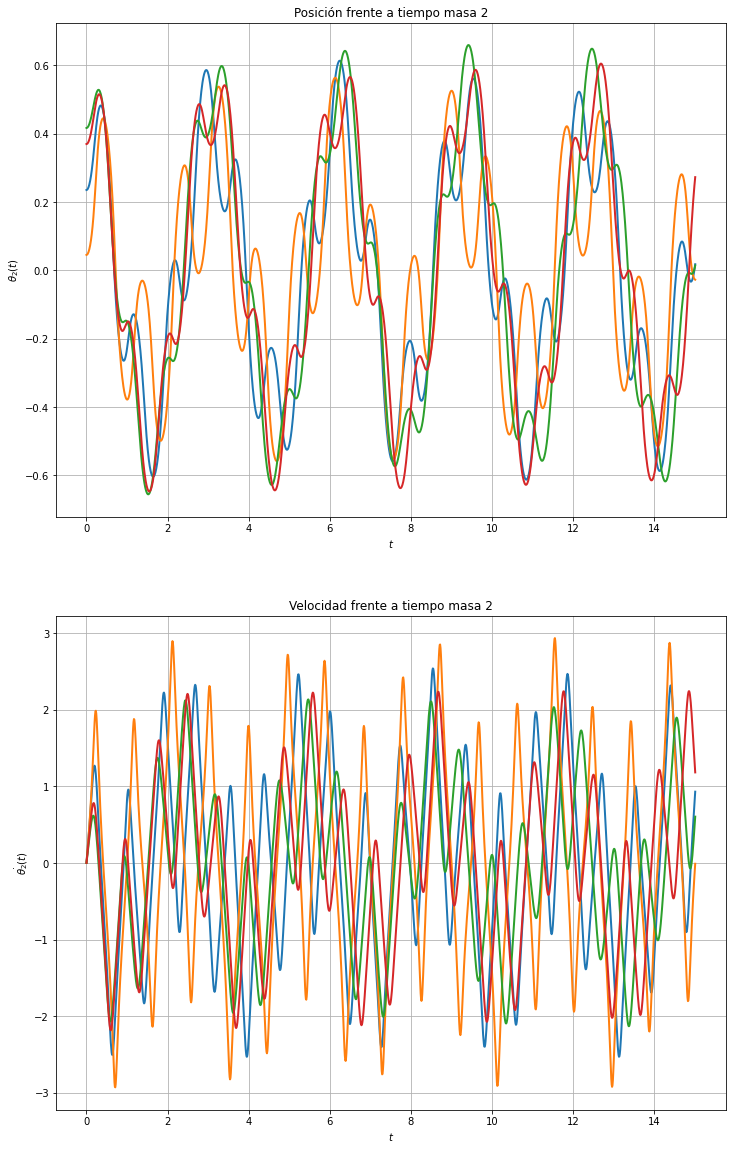

In [ ]:
muestra= 4 #Numero de condiciones iniciales distintas 
ang = np.random.rand(muestra) /2 #Numero aleatorio entre [0,0.5)

CI = np.zeros((4,muestra)) #creamos una matriz para alojar nuestras condiciones iniciales
x0,xf=0,15 #nuevo rango de tiempo

xs=[] #listas para almacenar resultados 
ys=[]
for i in range(muestra):
  CI[:,i] = np.array([(np.pi/5),0,((np.pi/6)-ang[i]),0]) #creamos cond ini
  xp, yp= int1(x0,xf,CI[:,i],pendulo_doble,h,RK_mej) #calculo de puntos
  xs.append(xp) #guardamos resultados
  ys.append(yp)

#Representamos

fig, ax = plt.subplots(nrows=2,figsize=(12, 20))

for i in range(muestra):
  ax[0].plot(xs[i],ys[i][:,2],'-',linewidth=2) 
  
ax[0].set_xlabel(r'$t$')
ax[0].set_ylabel(r'$\theta_2 (t)$')
ax[0].grid()
ax[0].set_title('Posición frente a tiempo masa 2')


for i in range(muestra):
  ax[1].plot(xs[i],ys[i][:,3],'-',linewidth=2)#color='tab:grey'  
  
ax[1].set_xlabel(r'$t$')
ax[1].set_ylabel(r'$\dot{\theta_2} (t)$')
ax[1].grid()
ax[1].set_title('Velocidad frente a tiempo masa 2')

plt.show()


Vemos claramente como con una pequeña variación en las condiciones iniciales, las posiciones y velocidades de nuestras masas 2 divergen completamente. Incluso con unas condiciones iniciales muy pequeñas (que podrían acercarse al régimen de pequeñas oscilaciones) vemos como rápidamente toman caminos muy distintos.

De hecho podemos observar fácilmente como sus velocidades se alteran más rápidamente. Esto nos puede indicar que dicha variable es incluso más caótica que la de la posición.

Este estudio no es más que otra prueba de que el sistema del péndulo doble es claramente caótico y que su predicción para cualquier instante de tiempo es materialmente imposible debido a las grandes fluctuaciones entre condiciones iniciales tan próximas.

Text(0.5, 1.0, 'Posición frente a tiempo masa 2')

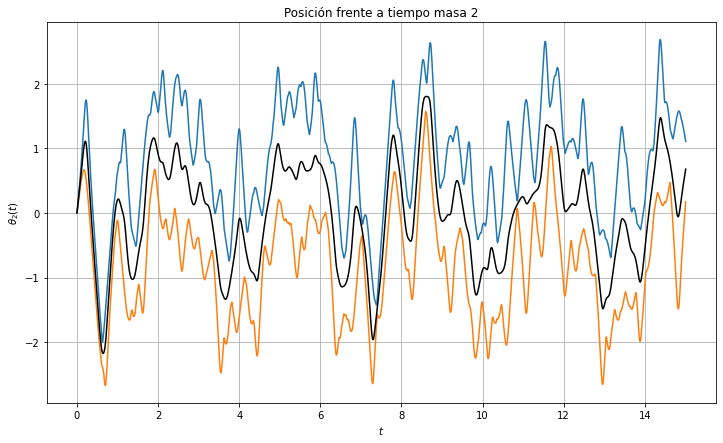

In [ ]:
#Percentiles 10 y 90 y media
p10 = np.percentile(ys,10, axis=0)
p90 = np.percentile(ys,90, axis=0)
media = np.mean(ys, axis=0)

#Representamos
fig, ax = plt.subplots(figsize=(12, 7))


ax.plot(xs[0],p10[:,3],color='tab:orange')
ax.plot(xs[0],p90[:,3], color='tab:blue')
ax.plot(xs[0],media[:,3],'k')

ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$\theta_2 (t)$')
ax.grid()
ax.set_title('Posición frente a tiempo masa 2')


###Conclusión:

Vemos que la media de los datos queda confinada entre los percentiles 10 y 90, como era de esperar.
Esta gráfica nos es de utilidad porque hemos utilizado unas condiciones iniciales que se acercan a pequeñas oscilaciones, si eligieramos unas condiciones iniciales más grandes, aunque las hagamos variar muy poco, el comportamiento caótico entraría en juego mucho antes y no nos sería de utilidad nada de lo observado.

De todas formas, aun habiendo elegido unas condiciones iniciales muy pequeñas, si dejamos evolucionar el tiempo suficiente el sistema también tenderá al caos.

Algo similar sucede con la atmósfera terrestre, que al tratarse de un sistema caótico no se pueden hacer predicciones exactas extendidas a cualquier tiempo, sino que contamos con varios modelos que hacen pequeñas variaciones en unas condiciones iniciales medidas en las distintas estaciones meteorológicas y después realizan un análisis estadístico de los resultados obtenidos. Por esta razón las predicciones se vuelven menos fiables cuanto más alejadas en el tiempo estén.


Esto es simplemente una pequeña muestra del potencial que tienen los procesos estocásticos en el mundo real y lo útiles que pueden llegar a ser. Se podría hacer un análisis mucho más profundo de las muchas características de este sistema pero no es el objetivo de este anexo.